<a href="https://colab.research.google.com/github/in-dist-adversarials/in_distribution_adversarial_examples/blob/main/demos/demo_imagenet_cma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/in-dist-adversarials/in_distribution_adversarial_examples.git
!pip install tensorflow-addons
!pip install pyheif
ROOT='/content/in_distribution_adversarial_examples'
MPI_ROOT='/content/in_distribution_adversarial_examples/single_view_mpi'
!wget https://storage.googleapis.com/stereo-magnification-public-files/models/single_view_mpi_full_keras.tar.gz -O "/content/in_distribution_adversarial_examples/single_view_mpi/single_view_mpi/single_view_mpi_full_keras.tar.gz"
!tar -xzvf /content/in_distribution_adversarial_examples/single_view_mpi/single_view_mpi/single_view_mpi_full_keras.tar.gz -C "/content/in_distribution_adversarial_examples/single_view_mpi/single_view_mpi/"

import sys
sys.path.append(ROOT)
sys.path.append(MPI_ROOT)

Cloning into 'in_distribution_adversarial_examples'...
remote: Enumerating objects: 572, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 572 (delta 0), reused 3 (delta 0), pack-reused 569
Receiving objects: 100% (572/572), 108.96 MiB | 7.01 MiB/s, done.
Resolving deltas: 100% (93/93), done.
Updating files: 100% (559/559), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 65.2 MB/s eta 0:00:00
--2023-06-12 18:41:29--  https://storage.googleapis.com/stereo-magnification-public-files/models/single_view_mpi_full_keras.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.128, 74.125.199.128, 142.250.99.128, ...
Conn

In [2]:
from tensorflow_addons import image as tfa_image
import numpy as np
import tensorflow as tf

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
import tensorflow as tf

from single_view_mpi.libs import mpi
from single_view_mpi.libs import nets

In [4]:
input = tf.keras.Input(shape=(None, None, 3))
output = nets.mpi_from_image(input)

model = tf.keras.Model(inputs=input, outputs=output)
print('Model created.')
model.load_weights('/content/in_distribution_adversarial_examples/single_view_mpi/single_view_mpi/single_view_mpi_full_keras/single_view_mpi_keras_weights')
print('Weights loaded.')


Model created.
Weights loaded.


In [5]:
import torch
import torchvision
from torchvision import models
from PIL import Image
import pyheif
import os
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from torchvision import transforms

In [6]:
image_url = 'https://animalia-bio.us-east-1.linodeobjects.com/animals/photos/full/1.25x1/smooth-green-snake-liochlorophis-vernalis-1.webp'
response = requests.get(image_url)
im = Image.open(BytesIO(response.content))

In [7]:
temp_im = im
temp_im = temp_im.resize((512, 512))
temp_im.save('/content/temp_image.png')

In [8]:
inputfile = '/content/temp_image.png'
input_rgb = tf.image.decode_image(tf.io.read_file(inputfile), dtype=tf.float32)
layers = model(input_rgb[tf.newaxis])[0]
depths = mpi.make_depths(1.0, 100.0, 32).numpy()

In [9]:
reference_pose = tf.constant(
    [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])
intrinsics = tf.constant([1.0, 1.0 * 16/9, 0.5, 0.5])

def render(xoffset, yoffset, zoffset):
  # The translation is the final column of the pose matrix
    target_pose = tf.constant(
    [[1.0, 0.0, 0.0, -xoffset],
     [0.0, 1.0, 0.0, -yoffset],
     [0.0, 0.0, 1.0, -zoffset]])
    image = mpi.render(layers, depths,
                     reference_pose, intrinsics,  # Reference view
                     target_pose, intrinsics,  # Target view
                     height=512, width=512)
    return image

In [10]:
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),  
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])

# with open('.imagenet_classes.txtf
imagenet_model = models.resnet18(pretrained=True)
imagenet_model.eval();

def predict_from_rendered(rendered, show = True, return_val = False):
    rendered_img = Image.fromarray((np.array(rendered)*255).astype('uint8'))

    img_t = transform(rendered_img)
    batch_t = torch.unsqueeze(img_t, 0)
    out = imagenet_model(batch_t)

    _, indices = torch.sort(out, descending=True)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    pred_idx = indices[0][:1].item()
    title = "Class:%s, Confidence:%0.02f"%(pred_idx, percentage[pred_idx].item()/100)

    if show:
        rendered_resized = rendered_img.resize((256, 256))
        center_cropped = rendered_resized.crop((16,16,240,240))
        plt.imshow(center_cropped)
        plt.title(title)
        plt.axis('off')
        plt.show()
    if return_val:
        return pred_idx, percentage[pred_idx].item()/100

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 54.0MB/s]


In [11]:
def objective(offsets, show = False):
    rendered_img = render(offsets[0], offsets[1], offsets[2])
    pred_id, percent = predict_from_rendered(rendered_img, False, True)
    if show == True:
        plt.imshow(rendered_img)
        plt.title('Pred:%s'%pred_id)
        plt.axis('off')
    return percent, pred_id

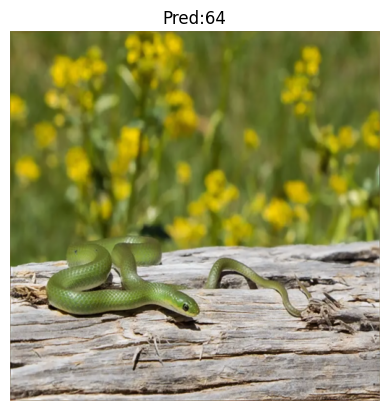

In [12]:
gt_prob, gt_cat = objective(np.array([0,0,0]), True)

In [13]:
import cma 
start_pos = np.array([0.0,0.0,0.0])
es = cma.CMAEvolutionStrategy(start_pos, 0.005)

es.optimize(objective, verb_disp = True, iterations=5, correct_prediction = gt_cat)

Predictions are :[64, 64, 64, 64, 64, 64, 64]
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 3.875806808471680e-01 1.0e+00 5.43e-03  4e-03  7e-03 0:04.1
Adversarial found, should stop now.
Adversarial found, should stop now.
Predictions are :[64, 64, 64, 46, 64, 64, 46]
    2     14 3.866101455688477e-01 1.5e+00 6.11e-03  5e-03  8e-03 0:07.5
Adversarial found, trying to stop.
    2     14 3.866101455688477e-01 1.5e+00 6.11e-03  5e-03  8e-03 0:07.5
termination by {}
best f-value = 0.38661014556884765
solution = [ 0.00607706 -0.00112326  0.00540924]


In [14]:
errored_indexes = [i for i in range(len(es.predictions)) if es.predictions[i] != gt_cat]

In [15]:
errored_settings = [es.prediction_settings[i] for i in errored_indexes][0]

In [16]:
rendered = render(errored_settings[0],  errored_settings[1],  errored_settings[2])
adversarial_image = Image.fromarray((np.array(rendered)*255).astype('uint8'))

original_rendered = render(0,0,0)
original_image = Image.fromarray((np.array(original_rendered)*255).astype('uint8'))

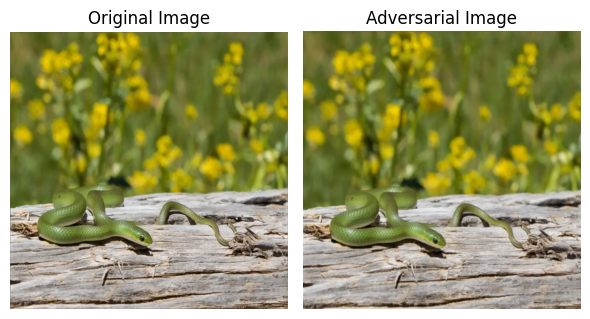

In [17]:
plt.figure(figsize=(6,12))
plt.subplot(1,2,1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(adversarial_image)
plt.title('Adversarial Image')
plt.axis('off')
plt.tight_layout()
plt.show()